# House Prices Prediction using TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

## Import the library

In [27]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [28]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.11.0
TensorFlow Decision Forests v1.2.0


## Load the dataset


In [29]:
train_file_path = "/kaggle/input/test12345/furData.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (32669, 7)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

In [30]:
dataset_df.head(3)

,Nof1Temp,Nof2Temp,Nof3Temp,Nof4Temp,SpeedStripMea,PROD_THK,RTFTempStrip
0,900.8,927.9,910.1,909.3,110.0,0.42,602.2931
1,900.6,928.3,910.2,909.8,110.0,0.42,611.4312
2,900.0,928.0,909.9,910.4,110.0,0.42,599.9946


* There are 79 feature columns. Using these features your model has to predict the house sale price indicated by the label column named `SalePrice`.

We will drop the `Id` column as it is not necessary for model training.

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


We can inspect the types of feature columns using the following code:

In [31]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32669 entries, 0 to 32668
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Nof1Temp       32669 non-null  float64
 1   Nof2Temp       32669 non-null  float64
 2   Nof3Temp       32669 non-null  float64
 3   Nof4Temp       32669 non-null  float64
 4   SpeedStripMea  32669 non-null  float64
 5   PROD_THK       32669 non-null  float64
 6   RTFTempStrip   32669 non-null  float64
dtypes: float64(7)
memory usage: 1.7 MB


## House Price Distribution

Now let us take a look at how the house prices are distributed.

In [32]:
print(dataset_df['RTFTempStrip'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['RTFTempStrip'], color='g', bins=100, hist_kws={'alpha': 0.4});

count    32669.000000
mean       685.385765
std         47.453716
min        382.306200
25%        668.109900
50%        684.816300
75%        705.559100
max       1197.783000
Name: RTFTempStrip, dtype: float64


KeyError: 'SalePrice'

<Figure size 900x800 with 0 Axes>

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [33]:
list(set(dataset_df.dtypes.tolist()))

[dtype('float64')]

In [34]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,Nof1Temp,Nof2Temp,Nof3Temp,Nof4Temp,SpeedStripMea,PROD_THK,RTFTempStrip
0,900.8,927.9,910.1,909.3,110.0,0.42,602.2931
1,900.6,928.3,910.2,909.8,110.0,0.42,611.4312
2,900.0,928.0,909.9,910.4,110.0,0.42,599.9946
3,900.1,927.8,909.9,909.7,110.0,0.42,604.5917
4,900.0,928.1,910.3,909.8,110.0,0.42,607.3387


Now let us plot the distribution for all the numerical features.

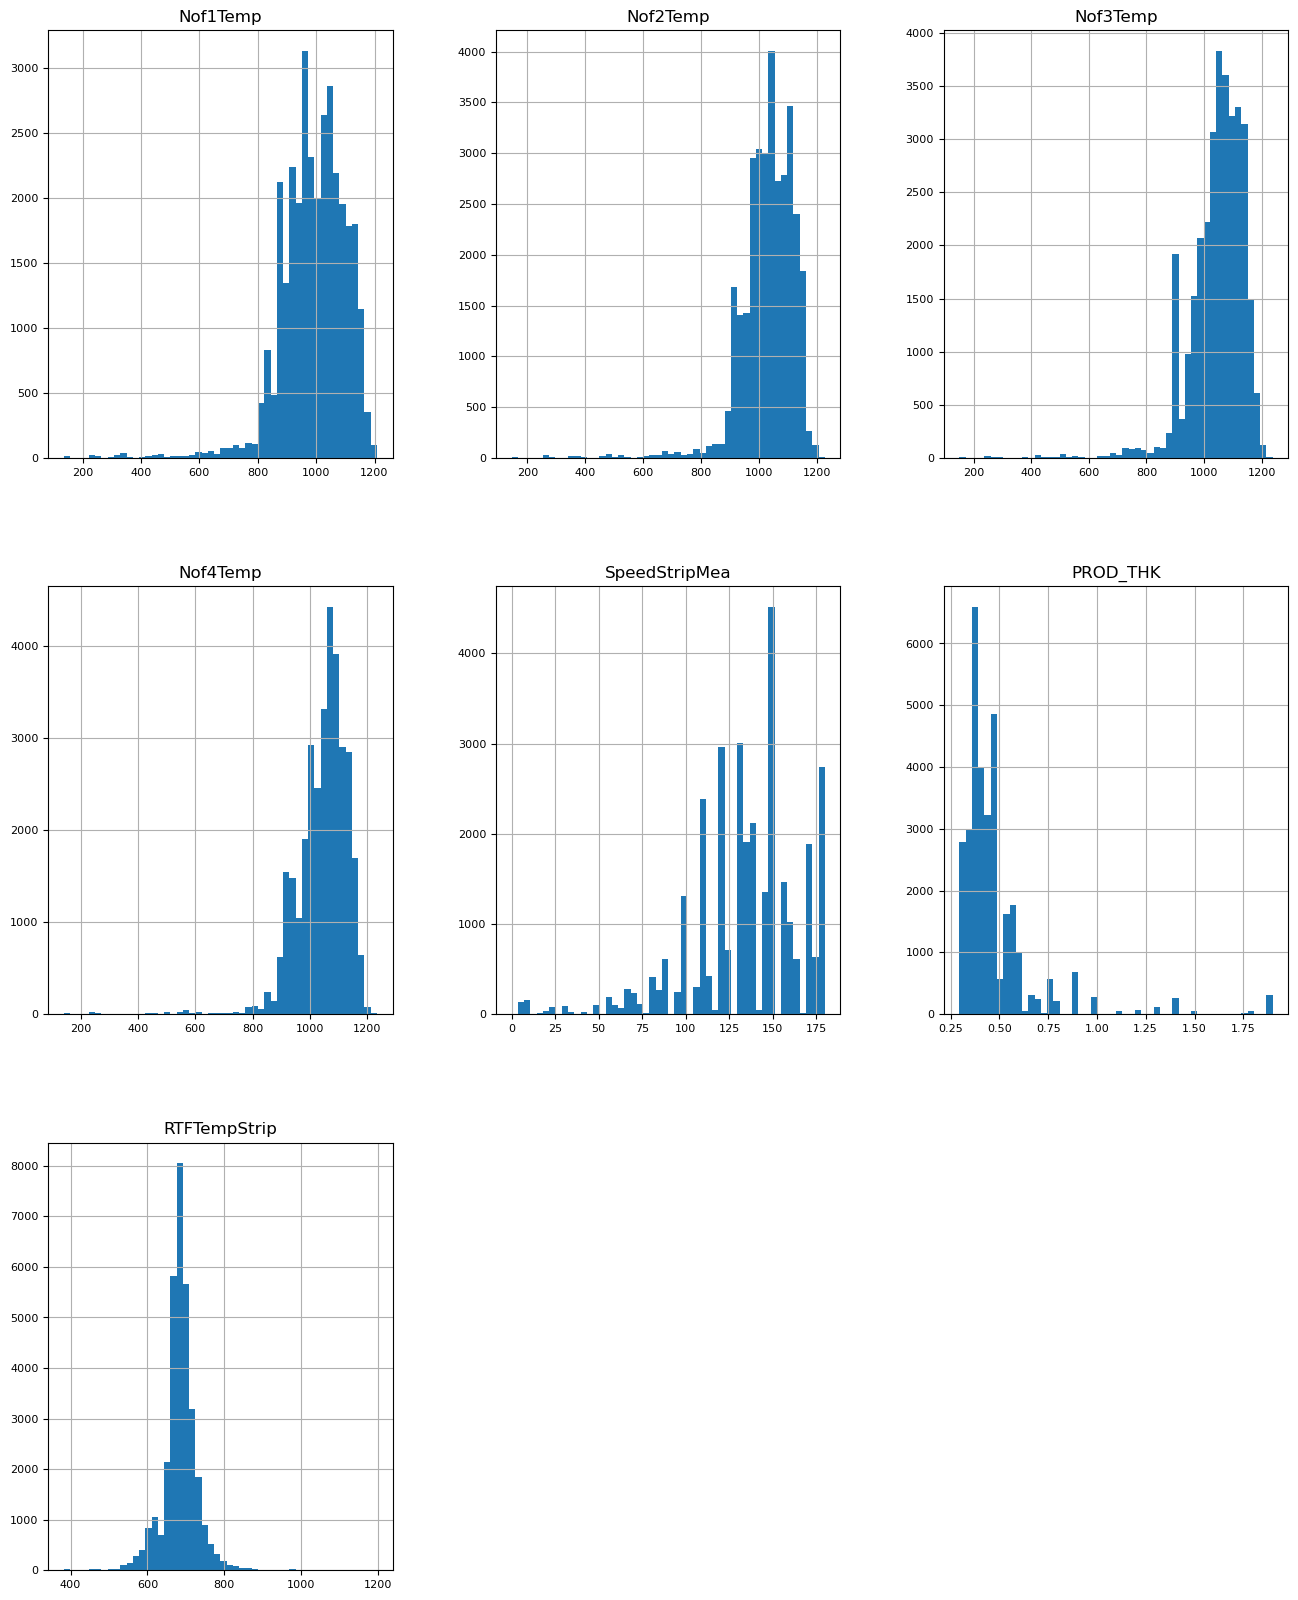

In [35]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Now let us split the dataset into training and testing datasets:

In [36]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

22907 examples in training, 9762 examples in testing.


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

In [37]:
label = 'RTFTempStrip'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

## Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [38]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

## How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

## Create a Random Forest

Today, we will use the defaults to create the Random Forest Model while specifiyng the task type as `tfdf.keras.Task.REGRESSION`.

In [39]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["rmse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmpxohb681t as temporary training directory


## Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [40]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.360335. Found 22907 examples.
Training model...


[INFO 2023-10-26T01:14:46.840143075+00:00 kernel.cc:1214] Loading model from path /tmp/tmpxohb681t/model/ with prefix 10b2792a43394086


Model trained in 0:00:11.010229


[INFO 2023-10-26T01:14:49.797649452+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 695336 node(s), and 6 input feature(s).
[INFO 2023-10-26T01:14:49.797725227+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-10-26T01:14:49.79776623+00:00 kernel.cc:1046] Use fast generic engine


Compiling model...
Model compiled.


## Visualize the model
One benefit of tree-based models is that you can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

In [41]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

## Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the Root Mean Squared Error (RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Smaller values are better for this hyperparameter.

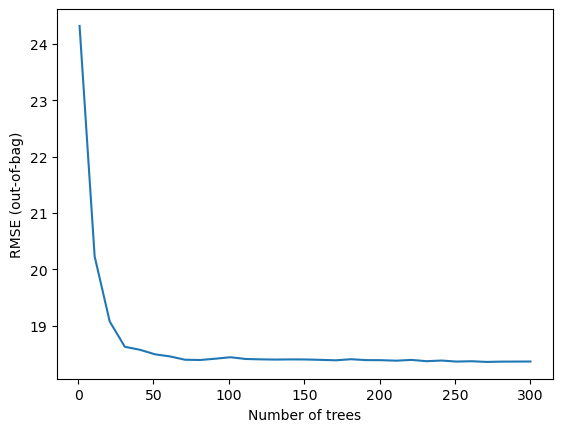

In [42]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

We can also see some general stats on the OOB dataset:

In [43]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=22907, accuracy=None, loss=None, rmse=18.36740813455984, ndcg=None, aucs=None, auuc=None, qini=None)

Now, let us run an evaluation using the validation dataset.

In [44]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core_inference.py", line 511, in test_function  *
        return step_function_trained(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core_inference.py", line 491, in run_step  *
        outputs = model.test_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1759, in test_step  **
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1122, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 484, in build
        y_pred, self._get_metric_objects, self._metrics, y_true, y_pred
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 650, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "/opt/conda/lib/python3.7/site-packages/keras/metrics/__init__.py", line 181, in get
        return deserialize(str(identifier))
    File "/opt/conda/lib/python3.7/site-packages/keras/metrics/__init__.py", line 140, in deserialize
        printable_module_name="metric function",
    File "/opt/conda/lib/python3.7/site-packages/keras/saving/legacy/serialization.py", line 558, in deserialize_keras_object
        f"Unknown {printable_module_name}: '{object_name}'. "

    ValueError: Unknown metric function: 'rmse'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [45]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_NODES
	 NUM_AS_ROOT


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [46]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("Nof4Temp" (1; #3), 140.0),
 ("Nof3Temp" (1; #2), 86.0),
 ("Nof2Temp" (1; #1), 57.0),
 ("Nof1Temp" (1; #0), 10.0),
 ("SpeedStripMea" (1; #5), 7.0)]

Plot the variable importances from the inspector using Matplotlib

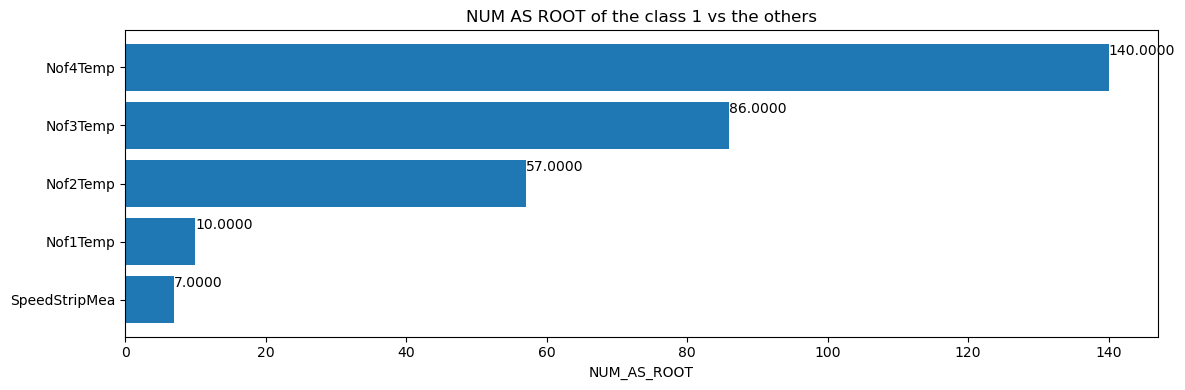

In [47]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

# Submission
Finally predict on the competition test data using the model.

In [23]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()


2/2 [==============================] - 1s 25ms/step


,Id,SalePrice
0,1461,127907.765625
1,1462,151596.593750
2,1463,182365.703125
3,1464,186616.218750
4,1465,196312.781250


In [24]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 25ms/step


,Id,SalePrice
0,1461,127907.765625
1,1462,151596.593750
2,1463,182365.703125
3,1464,186616.218750
4,1465,196312.781250
